# Various models on ML-1m in Tensorflow

## Load dependencies

In [ ]:
!pip install -q tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.3 MB/s 


In [ ]:
!wget -q --show-progress -O ratings.dat https://github.com/RecoHut-Datasets/movielens_1m/raw/main/ml1m_ratings.dat

ratings.dat         100%[===================>]  20.59M  37.8MB/s    in 0.5s    


In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import os,sys,inspect
import gc
from tqdm.notebook import tqdm
import random
import heapq

from sklearn.metrics import precision_score, recall_score,  roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import optimizers, callbacks, layers, losses
from tensorflow.keras.layers import Dense, Concatenate, Activation, Add, BatchNormalization, Dropout, Input, Embedding, Flatten, Multiply
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def eval_hit(model, df, test, user_id, item_ids, top_k):
    df = pd.concat([df, test])
    items = list(set(item_ids) - set(df[df['userId']==user_id][df['rating']==1]['movieId'].values))
    np.random.shuffle(items)
    items = items[:99]
    items.append(test[test['userId']==user_id]['movieId'].values[0])
    items = np.array(items).reshape(-1, 1)

    user = np.full(len(items), user_id).reshape(-1, 1)

    preds = model.predict([user, items]).flatten()
    item_to_pred = {item: pred for item, pred in zip(items.flatten(), preds)}

    top_k = heapq.nlargest(top_k, item_to_pred, key=item_to_pred.get)
    
    if items[-1][0] in top_k:
            return 1
    return 0


def eval_NDCG(model, df, test, user_id, item_ids, top_k):
    df = pd.concat([df, test])
    items = list(set(item_ids) - set(df[df['userId']==user_id][df['rating']==1]['movieId'].values))
    np.random.shuffle(items)
    items = items[:99]
    items.append(test[test['userId']==user_id]['movieId'].values[0])
    items = np.array(items).reshape(-1, 1)

    user = np.full(len(items), user_id).reshape(-1, 1)

    preds = model.predict([user, items]).flatten()
    item_to_pred = {item: pred for item, pred in zip(items.flatten(), preds)}

    top_k = heapq.nlargest(top_k, item_to_pred, key=item_to_pred.get)
    
    for i, item in enumerate(top_k, 1):
        if item == test[test['userId']==user_id]['movieId'].values:
            return 1 / np.log2(i+1)
    return 0


def eval_hit_wrapper(model, df, test, item_ids, top_k):
    def f(user_id):
        return eval_hit(model, df, test, user_id, item_ids, top_k)
    return f


def eval_NDCG_wrapper(model, df, test, item_ids, top_k):
    def f(user_id):
        return eval_NDCG(model, df, test, user_id, item_ids, top_k)
    return f

In [ ]:
def load_data(filepath, threshold=0):
    df = pd.read_csv(filepath,
                     sep="\t",
                     header=None,
                     engine='python',
                     names=['userId', 'movieId', 'rating', 'time'])
    df = df.drop('time', axis=1)
    df['userId'] = df['userId'].astype(int)
    df['movieId'] = df['movieId'].astype(int)
    df['rating'] = df['rating'].astype(float)
    
    df = df[['userId', 'movieId', 'rating']]
    if threshold > 0:
        df['rating'] = np.where(df['rating']>threshold, 1, 0)  
    else:
        df['rating'] = 1.
    m_codes = df['movieId'].astype('category').cat.codes
    u_codes = df['userId'].astype('category').cat.codes
    df['movieId'] = m_codes
    df['userId'] = u_codes

    return df


def add_negative(df, uiid, times=4):
    df_ = df.copy()
    user_id = df_['userId'].unique()
    item_id = df_['movieId'].unique()
    
    for i in tqdm(user_id):
        cnt = 0
        n = len(df_[df_['userId']==i])
        n_negative = min(n*times, len(item_id)-n-1)
        available_negative = list(set(uiid) - set(df[df['userId']==i]['movieId'].values))
        
        new = np.random.choice(available_negative, n_negative, replace=False)
        new = [[i, j, 0] for j in new]
        df_ = df_.append(pd.DataFrame(new, columns=df.columns), ignore_index=True)
    
    return df_


def extract_from_df(df, n_positive, n_negative):
    df_ = df.copy()
    rtd = []
    
    user_id = df['userId'].unique()
    
    for i in tqdm(user_id):
        rtd += list(np.random.choice(df[df['userId']==i][df['rating']==1]['movieId'].index, n_positive, replace=False))
        rtd += list(np.random.choice(df[df['userId']==i][df['rating']==0]['movieId'].index, n_negative, replace=False))
        
    return rtd

In [ ]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
gpus = tf.config.experimental.list_physical_devices('GPU')

In [ ]:
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [ ]:
tf.config.experimental.set_memory_growth(gpus[0], True)

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
def mish(x):
    return x*tf.math.tanh(tf.math.softplus(x))

def leakyrelu(x, factor=0.2):
    return tf.maximum(x, factor*x)

## NeuMF

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
# Negative Resampling
df = add_negative(df, uiid, 4)

# Reshuffling
idx = list(df.index)
np.random.shuffle(idx)
df = df.loc[idx]

# Train/Val/Test Split
rtd = extract_from_df(df, 2, 0)
train = df.drop(rtd)
val = df.loc[rtd]
rtd = extract_from_df(val, 1, 0)
test = val.drop(rtd)
val = val.loc[rtd]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

  0%|          | 0/6040 [00:00<?, ?it/s]

In [ ]:
df.shape, train.shape, val.shape, test.shape

((4844870, 3), (4832790, 3), (6040, 3), (6040, 3))

### Model architecture

In [ ]:
def build_gmf(u_dim, i_dim, gmf_dim):
    u_input = Input(shape=(1, ))
    i_input = Input(shape=(1, ))

    u_emb_gmf = Flatten()(Embedding(u_dim, gmf_dim, input_length=u_input.shape[1])(u_input))
    i_emb_gmf = Flatten()(Embedding(i_dim, gmf_dim, input_length=i_input.shape[1])(i_input))

    # gmf
    mul = Multiply()([u_emb_gmf, i_emb_gmf])

    out = Dense(1)(mul)

    return Model([u_input, i_input], out, name='GMF')

def build_mlp(u_dim, i_dim, mlp_dim):
    u_input = Input(shape=(1, ))
    i_input = Input(shape=(1, ))
    
    u_emb_mlp = Flatten()(Embedding(u_dim, mlp_dim, input_length=u_input.shape[1])(u_input))
    i_emb_mlp = Flatten()(Embedding(i_dim, mlp_dim, input_length=i_input.shape[1])(i_input))

    # mlp
    concat = Concatenate()([u_emb_mlp, i_emb_mlp])
    h = Dense(128, activation='relu')(concat)
    h = Dense(64, activation='relu')(h)
    h = Dropout(0.2)(h)

    out = Dense(1)(h)

    return Model([u_input, i_input], out, name='MLP')

def build_nmf(u_dim, i_dim, gmf_dim, mlp_dim):
    u_input = Input(shape=(1, ))
    i_input = Input(shape=(1, ))

    u_emb_gmf = Flatten()(Embedding(u_dim, gmf_dim, input_length=u_input.shape[1])(u_input))
    i_emb_gmf = Flatten()(Embedding(i_dim, gmf_dim, input_length=i_input.shape[1])(i_input))

    u_emb_mlp = Flatten()(Embedding(u_dim, mlp_dim, input_length=u_input.shape[1])(u_input))
    i_emb_mlp = Flatten()(Embedding(i_dim, mlp_dim, input_length=i_input.shape[1])(i_input))

    # gmf
    mul = Multiply()([u_emb_gmf, i_emb_gmf])

    # mlp
    concat = Concatenate()([u_emb_mlp, i_emb_mlp])
    h = Dense(128, activation='relu')(concat)
    h = Dense(64, activation='relu')(h)
    h = Dropout(0.2)(h)

    con = Concatenate()([mul, h])
    out = Dense(1)(con)

    return Model([u_input, i_input], out, name='NMF')

### Training

In [ ]:
class ValCallback(callbacks.Callback):
    def __init__(self):
        self.best_score = 0
        self.bw = None
        self.score_hist = []
        self.score_hist_ = []
    
    def on_epoch_end(self, epochs, logs=None):
        if epochs%1 == 0:
            uid = np.random.choice(uuid, int(len(uuid)*0.3), replace=False)
            hits = list(map(eval_hit_wrapper(self.model, train, val, uiid, 10), uid))
            score = sum(hits)
            self.score_hist.append(score)
            self.score_hist_.append(score/len(hits))
            if self.best_score < score:
                self.bw = self.model.get_weights()
                self.best_score = score

In [ ]:
gmf = build_gmf(len(uuid), len(uiid), 16)
gmf.compile(optimizer=optimizers.Adam(2e-4), loss=losses.BinaryCrossentropy(from_logits=True))

gmf_cb = ValCallback()

hist_gmf = gmf.fit([train['userId'].values, train['movieId'].values],
                   train['rating'].values,
                   shuffle=True,
                   epochs=10,
                  callbacks=[gmf_cb],
                  validation_split=0.1)

In [ ]:
mlp = build_mlp(len(uuid), len(uiid), 16)
mlp.compile(optimizer=optimizers.Adam(2e-4), loss=losses.BinaryCrossentropy(from_logits=True))

mlp_cb = ValCallback()

hist_mlp = mlp.fit([train['userId'].values, train['movieId'].values],
                   train['rating'].values,
                   shuffle=True,
                   epochs=10,
                  callbacks=[mlp_cb],
                  validation_split=0.1)

In [ ]:
nmf = build_nmf(len(uuid), len(uiid), 16, 16)
nmf.compile(optimizer=optimizers.Adam(2e-4), loss=losses.BinaryCrossentropy(from_logits=True))

nmf_cb = ValCallback()

hist_nmf = nmf.fit([train['userId'].values, train['movieId'].values],
                   train['rating'].values,
                   shuffle=True,
                   epochs=10,
                  callbacks=[nmf_cb],
                  validation_split=0.1)

### Losses

In [ ]:
plt.plot(hist_gmf.history['loss'], label='GMF')
plt.plot(hist_mlp.history['loss'], label='MLP')
plt.plot(hist_nmf.history['loss'], label='NMF')
plt.legend()

In [ ]:
plt.plot(gmf_cb.score_hist, label='GMF')
plt.plot(mlp_cb.score_hist, label='MLP')
plt.plot(nmf_cb.score_hist, label='NMF')
plt.legend()

### Hit@10

In [ ]:
# GMF
hits_gmf10 = list(map(eval_hit_wrapper(gmf, train, test, uiid, 10), uuid))
print(sum(hits_gmf10)/len(hits_gmf10))

# MLP
hits_mlp10 = list(map(eval_hit_wrapper(mlp, train, test, uiid, 10), uuid))
print(sum(hits_mlp10)/len(hits_mlp10))

# NMF
hits_nmf10 = list(map(eval_hit_wrapper(nmf, train, test, uiid, 10), uuid))
print(sum(hits_nmf10)/len(hits_nmf10))

### NDCG@10

In [ ]:
# GMF
ndcg_gmf10 = list(map(eval_NDCG_wrapper(gmf, train, test, uiid, 10), uuid))
print(sum(ndcg_gmf10)/len(ndcg_gmf10))

# MLP
ndcg_mlp10 = list(map(eval_NDCG_wrapper(mlp, train, test, uiid, 10), uuid))
print(sum(ndcg_mlp10)/len(ndcg_mlp10))

# NMF
ndcg_nmf10 = list(map(eval_NDCG_wrapper(nmf, train, test, uiid, 10), uuid))
print(sum(ndcg_nmf10)/len(ndcg_nmf10))

## AFM

### Abstract

[Attentional Factorization Machines: Learning the Weight of Feature Interactions via Attention Networks](https://www.ijcai.org/proceedings/2017/0435.pdf)

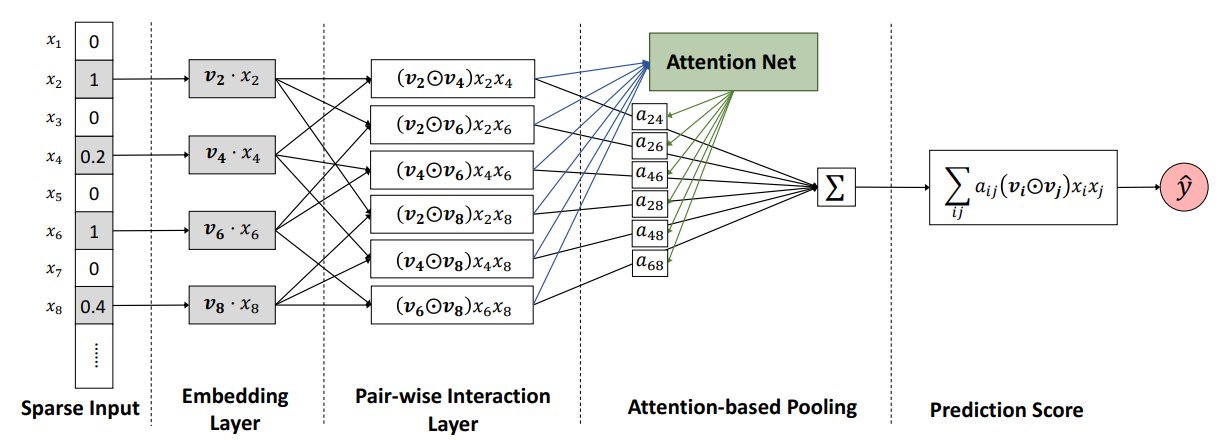

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

### Model architecture

In [ ]:
class AFM_layer(keras.Model):
    def __init__(self, x_dims, latent_dim, att_dim, l2_emb=1e-4):
        super(AFM_layer, self).__init__()
        self.x_dims = x_dims
        self.latent_dim = latent_dim
        self.att_dim = att_dim
        
        
        self.embedding = Embedding(sum(x_dims)+1, latent_dim, input_length=1, embeddings_regularizer=l2(l2_emb))
        
        self.linear = Dense(1)
        self.att_dense1 = Dense(att_dim)
        self.att_dense2 = Dense(1)
        self.final_dense = Dense(1)

    def call(self, inputs):
        cat_ = [tf.squeeze(tf.one_hot(feat, self.x_dims[i]), 1) for i, feat in enumerate(inputs)]
        X_cat = tf.concat(cat_, 1)
        X = tf.concat(inputs, 1)

        linear_terms = self.linear(X_cat)
        non_zero_emb = self.embedding(X + tf.constant((0, *np.cumsum(self.x_dims)))[:-1])

        n = len(self.x_dims)
        r = []; c = []
        for i in range(n-1):
            for j in range(i+1, n):
                r.append(i), c.append(j)
        p = tf.gather(non_zero_emb, r, axis=1)
        q = tf.gather(non_zero_emb, c, axis=1)
        pairwise = p*q
        
        att_score = tf.nn.relu(self.att_dense1(pairwise))
        att_score = tf.nn.softmax(self.att_dense2(att_score), axis=1)

        att_output = tf.reduce_sum(att_score * pairwise, axis=1)

        att_output = self.final_dense(att_output)
        
        y_hat = att_output + linear_terms

        return y_hat

In [ ]:
class AFM(tf.keras.Model):
    def __init__(self, x_dim, latnt_dim, att_dim):
        super(AFM, self).__init__()
        self.afm = AFM_layer(x_dim, latnt_dim, att_dim)

    def call(self, inputs):
        outputs = self.afm(inputs)
#         outputs = tf.nn.sigmoid(outputs)
        return outputs

### Training

In [ ]:
afm = AFM((len(uuid), len(uiid)), 8, 8)
afm.compile(loss=losses.BinaryCrossentropy(from_logits=True), optimizer=optimizers.Adam())
afm.fit([train['userId'].values.astype(np.int32), train['movieId'].values.astype(np.int32)], 
       train['rating'].values,
      epochs=10,
      shuffle=True,
      validation_split=0.1)

### Evaluation

In [ ]:
pred = afm.predict([test['userId'].values.astype(np.int32), test['movieId'].values.astype(np.int32)])
np.sum(np.where(pred>0., 1, 0).flatten() == test['rating'].values) / len(pred)

In [ ]:
print(roc_auc_score(test['rating'].values, pred))
print(precision_score(test['rating'].values, np.where(pred>0., 1, 0)))
print(recall_score(test['rating'].values, np.where(pred>0., 1, 0)))

## AutoInt

### Abstract

[AutoInt: Automatic Feature Interaction Learning via Self-Attentive Neural Networks](https://arxiv.org/pdf/1810.11921.pdf)

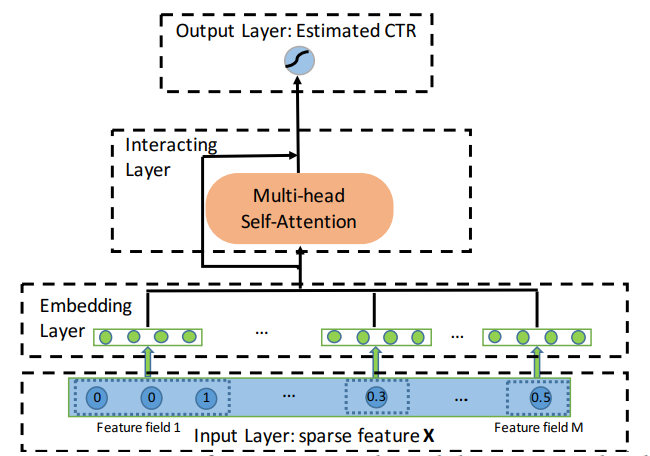

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

In [ ]:
tr_X = np.stack([train['userId'].values.astype(np.int32), train['movieId'].values.astype(np.int32)], 1)
test_X = np.stack([test['userId'].values.astype(np.int32), test['movieId'].values.astype(np.int32)], 1)

tr_X.shape, test_X.shape

((850177, 2), (150032, 2))

### Model architecture

In [ ]:
class MHA(layers.Layer):
    def __init__(self, emb_size, head_num, use_resid=True):
        super(MHA, self).__init__()
        
        self.emb_size = emb_size
        self.head_num = head_num
        self.use_resid = use_resid
        
        self.flatten = Flatten()
        
        self.att = tfa.layers.MultiHeadAttention(emb_size, head_num)
        
    def build(self, input_shape):
        units = self.emb_size * self.head_num
        
        self.W_q = Dense(units)
        self.W_k = Dense(units)
        self.W_v = Dense(units)
        if self.use_resid:
            self.W_res = Dense(units)
            
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        q = self.W_q(inputs)
        k = self.W_k(inputs)
        v = self.W_v(inputs)
        
        out = self.att([q, k, v])

        if self.use_resid:
            out = out + self.W_res((inputs))
            
        out = tf.nn.relu(out)
        
        return out

In [ ]:
class AutoInt(tf.keras.Model):
    def __init__(self, x_dims, latent_dim, att_sizes, att_heads, l2_emb=1e-4):
        super(AutoInt, self).__init__()
        
        self.x_dims = x_dims
        self.latent_dim = latent_dim

        self.embedding = Embedding(sum(x_dims)+1, latent_dim, input_length=1, embeddings_regularizer=l2(l2_emb))
        
        self.linear = Dense(1)
        
        self.att_layers = [MHA(a, h) for a, h in zip(att_sizes, att_heads)]
        
        self.flatten =  Flatten()
        
    def call(self, inputs):
        emb = self.embedding(inputs + tf.constant((0, *np.cumsum(self.x_dims)))[:-1])
        
        att = emb
        for att_layer in self.att_layers:
            att = att_layer(att)
        
        out = self.linear(self.flatten(att))
        
        return out

### Training

In [ ]:
autoint = AutoInt((len(uuid), len(uiid)), 8, [8, 8], [2, 2])
autoint.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
            optimizer=optimizers.Adam(2e-4))
hist = autoint.fit(tr_X, 
           train['rating'].values,
          epochs=10,
          shuffle=True,
          validation_split=0.1)

Epoch 1/10
 6567/23912 [=======>......................] - ETA: 2:03 - loss: 0.0146

### Evaluation

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

In [ ]:
pred = autoint.predict(test_X)
np.sum(np.where(pred>0., 1, 0).flatten() == test['rating'].values) / len(pred)

In [ ]:
print(roc_auc_score(test['rating'].values, pred))
print(precision_score(test['rating'].values, np.where(pred>0., 1, 0)))
print(recall_score(test['rating'].values, np.where(pred>0., 1, 0)))

## CDN

### Abstract

[A hybrid recommender system for suggesting CDN (content delivery network)](https://github.com/lucashu1/CDN-RecSys)

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

In [ ]:
tr_X = np.stack([train['userId'].values.astype(np.int32), train['movieId'].values.astype(np.int32)], 1)
test_X = np.stack([test['userId'].values.astype(np.int32), test['movieId'].values.astype(np.int32)], 1)

tr_X.shape, test_X.shape

((850177, 2), (150032, 2))

### Model architecture

In [ ]:
class CrossNetwork(layers.Layer):
    def __init__(self, n_layers):
        super(CrossNetwork, self).__init__()
        self.n_layers = n_layers
    
    def build(self, input_shape):
        dim = input_shape[-1]
        self.cross_weights = [self.add_weight(shape=(dim, 1), 
                                        initializer=tf.random_normal_initializer(),
                                       trainable=True,
                                       name=f'cross_weight_{i}') for i in range(self.n_layers)]
    
        self.cross_biases = [self.add_weight(shape=(dim, 1),
                                      initializer=tf.random_normal_initializer(),
                                      trainable=True,
                                      name=f'cross_bias_{i}') for i in range(self.n_layers)]
    def call(self, inputs):
        x_0 = tf.expand_dims(inputs, -1)
        x_l = x_0
        for i in range(self.n_layers):
            x_l1 = tf.tensordot(x_l, self.cross_weights[i], axes=[1, 0])
            x_l = tf.matmul(x_0, x_l1) + self.cross_biases[i]
            
        x_l = tf.squeeze(x_l, -1)
        
        return x_l

class DeepNetwork(layers.Layer):
    def __init__(self, units, activation='relu'):
        super(DeepNetwork, self).__init__()
        
        self.layers = [Dense(unit, activation=activation) for unit in units]
    
    def call(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
            
        return x

In [ ]:
class DCN(Model):
    def __init__(self, x_dims, latent_dim, n_cross_layers, hidden_units, activation='relu', l2_emb=1e-4):
        super(DCN, self).__init__()
        self.x_dims = x_dims
        self.latent_dim = latent_dim
        
        self.cross_layers = CrossNetwork(n_cross_layers)
        self.deep_layers = DeepNetwork(hidden_units, activation)
        
        self.embedding = Embedding(sum(x_dims)+1, latent_dim, input_length=1, embeddings_regularizer=l2(l2_emb))
    
        self.flatten = Flatten()
        self.final_dense = Dense(1)
        
    def call(self, inputs):
        embed = self.embedding(inputs + tf.constant((0, *np.cumsum(self.x_dims)))[:-1])
        embed = self.flatten(embed)
        
        # if continuous, concat with embed
        
        cross_out = self.cross_layers(embed)
        deep_out = self.deep_layers(embed)
        
        out = tf.concat([cross_out, deep_out], 1)
        out = self.final_dense(out)
        
        return out

### Training

In [ ]:
dcn = DCN((len(uuid), len(uiid)), 8, 2, [128,64])
dcn.compile(optimizer='adam',
           loss = losses.BinaryCrossentropy(from_logits=True))

dcn.fit(tr_X,
       train['rating'].values,
       epochs=10,
       shuffle=True)

### Evaluation

In [ ]:
pred = dcn.predict(test_X)
np.sum(np.where(pred>0., 1, 0).flatten() == test['rating'].values) / len(pred)

In [ ]:
print(roc_auc_score(test['rating'].values, pred))
print(precision_score(test['rating'].values, np.where(pred>0., 1, 0)))
print(recall_score(test['rating'].values, np.where(pred>0., 1, 0)))

## DeepFM

### Abstract

[DeepFM: A Factorization-Machine based Neural Network for CTR Prediction](https://arxiv.org/pdf/1703.04247.pdf)

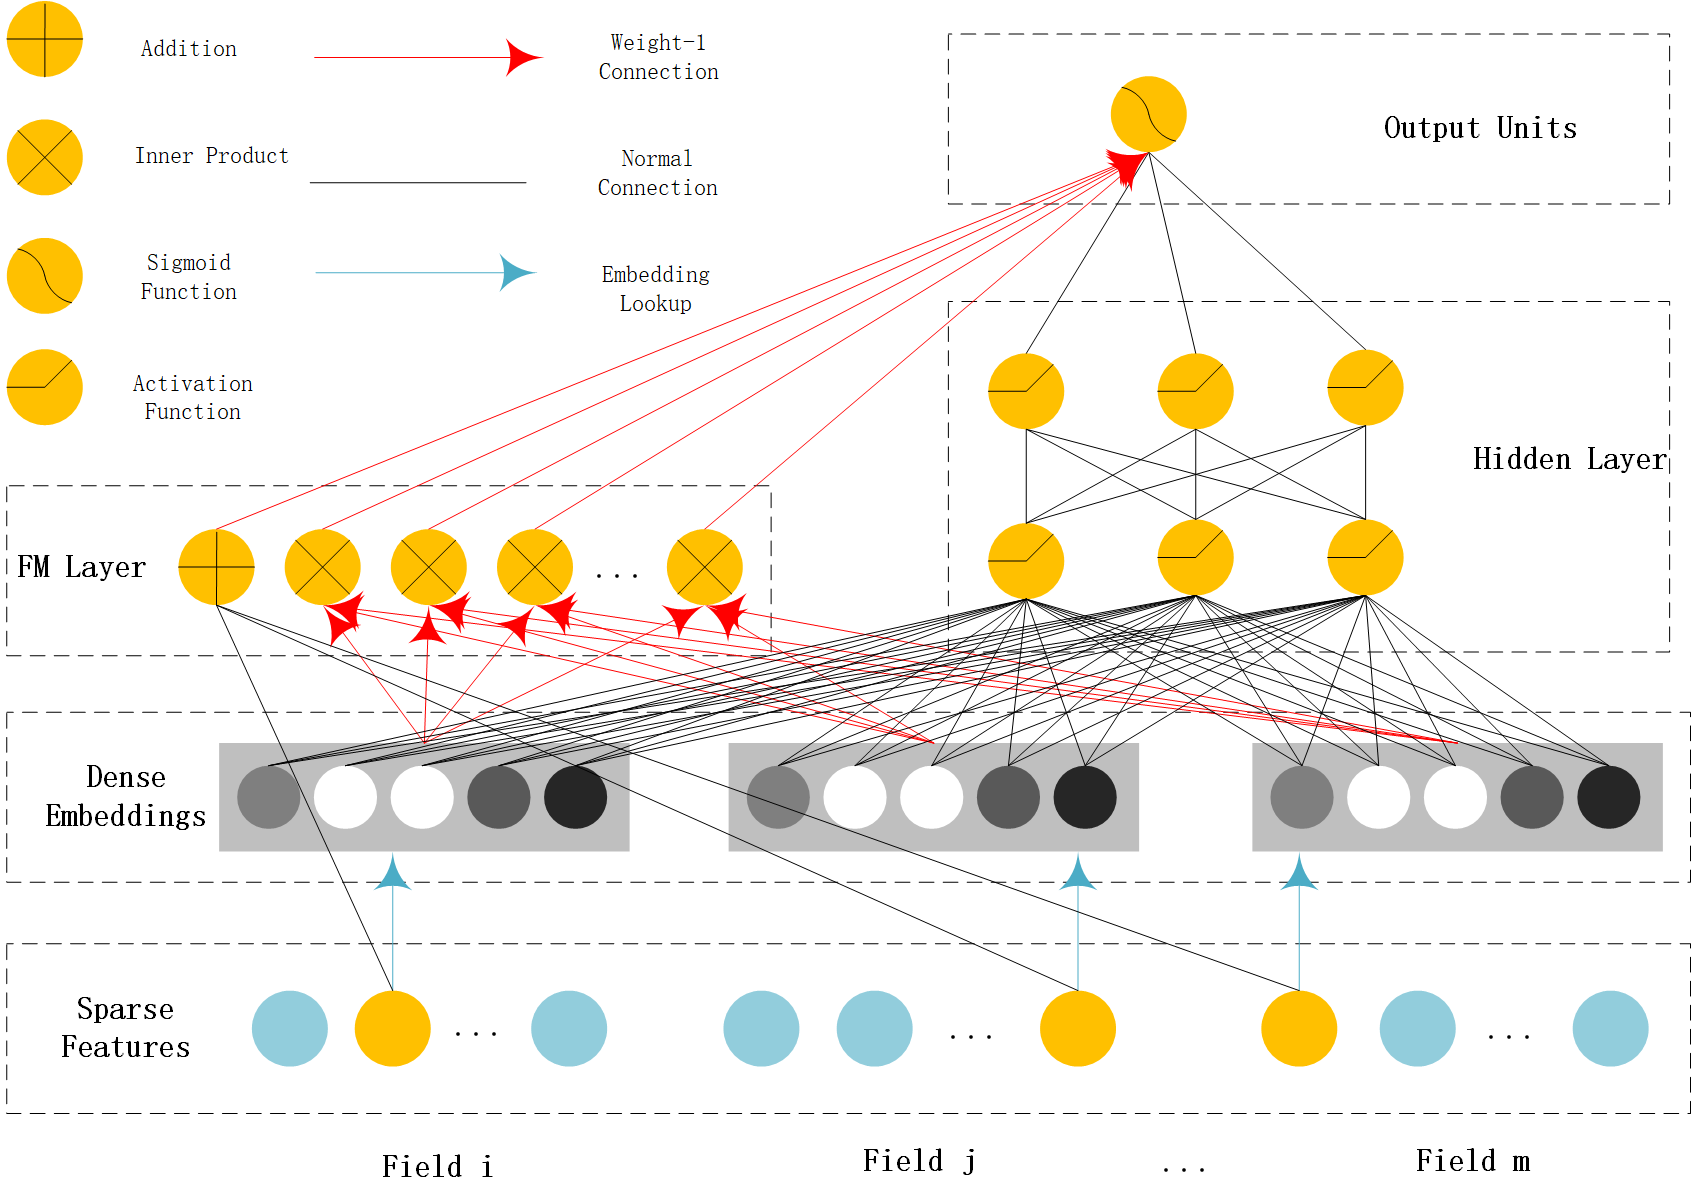

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

In [ ]:
tr_X = np.stack([train['userId'].values.astype(np.int32), train['movieId'].values.astype(np.int32)], 1)
test_X = np.stack([test['userId'].values.astype(np.int32), test['movieId'].values.astype(np.int32)], 1)

tr_X.shape, test_X.shape

((850177, 2), (150032, 2))

### Model architecture

In [ ]:
class FM_layer(keras.Model):
    def __init__(self, latent_dim, w_reg=1e-4, v_reg=1e-4):
        super(FM_layer, self).__init__()
        self.latent_dim = latent_dim
        
        self.w_reg = w_reg
        self.v_reg = v_reg

    def build(self, input_shape):
        self.w_0 = self.add_weight(shape=(1, ),
                                  initializer=tf.zeros_initializer(),
                                  trainable=True)
        
        self.w = self.add_weight(shape=(input_shape[-1], 1), 
                             initializer=tf.random_normal_initializer(),
                                trainable=True,
                                regularizer=l2(self.w_reg))
        
        self.V = self.add_weight(shape=(input_shape[-1], self.latent_dim), 
                             initializer=tf.random_normal_initializer(),
                                trainable=True,
                                regularizer=l2(self.v_reg))

    def call(self, inputs):
        linear_terms = tf.reduce_sum(tf.matmul(inputs, self.w), axis=1)

        interactions = 0.5 * tf.reduce_sum(
            tf.pow(tf.matmul(inputs, self.V), 2)
            - tf.matmul(tf.pow(inputs, 2), tf.pow(self.V, 2)),
            1,
            keepdims=False
        )

        y_hat = (self.w_0 + linear_terms + interactions)

        return y_hat

In [ ]:
class DeepFM(tf.keras.Model):
    def __init__(self, x_dims, latent_dim, l2_emb=1e-4):
        super(DeepFM, self).__init__()
        
        self.x_dims = x_dims
        self.latent_dim = latent_dim

        self.embedding = Embedding(sum(x_dims)+1, latent_dim, input_length=1, embeddings_regularizer=l2(l2_emb))
        self.fm_layer = FM_layer(latent_dim)
        self.dnn_layers = self.build_dnn()
        self.flatten =  Flatten()

    def build_dnn(self):
        model = Sequential()
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))
        
        return model
        
    def call(self, inputs):        
        emb = self.embedding(inputs + tf.constant((0, *np.cumsum(self.x_dims)))[:-1])
        embed = self.flatten(emb)

        fm_out = self.fm_layer(embed)

        deep_out = self.dnn_layers(embed)

        outputs = fm_out + tf.squeeze(deep_out)
        
        return outputs

### Training

In [ ]:
dfm = DeepFM((len(uuid), len(uiid)), 8)
dfm.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
            optimizer=optimizers.Adam())

dfm.fit(tr_X, 
       train['rating'].values,
      epochs=10,
      shuffle=True,
      validation_split=0.1)

### Evaluation

In [ ]:
pred = dfm.predict(test_X)
np.sum(np.where(pred>0., 1, 0).flatten() == test['rating'].values) / len(pred)

In [ ]:
print(roc_auc_score(test['rating'].values, pred))
print(precision_score(test['rating'].values, np.where(pred>0., 1, 0)))
print(recall_score(test['rating'].values, np.where(pred>0., 1, 0)))

## FM

### Abstract

[Factorization Machines for Data with Implicit Feedback](https://arxiv.org/abs/1812.08254)

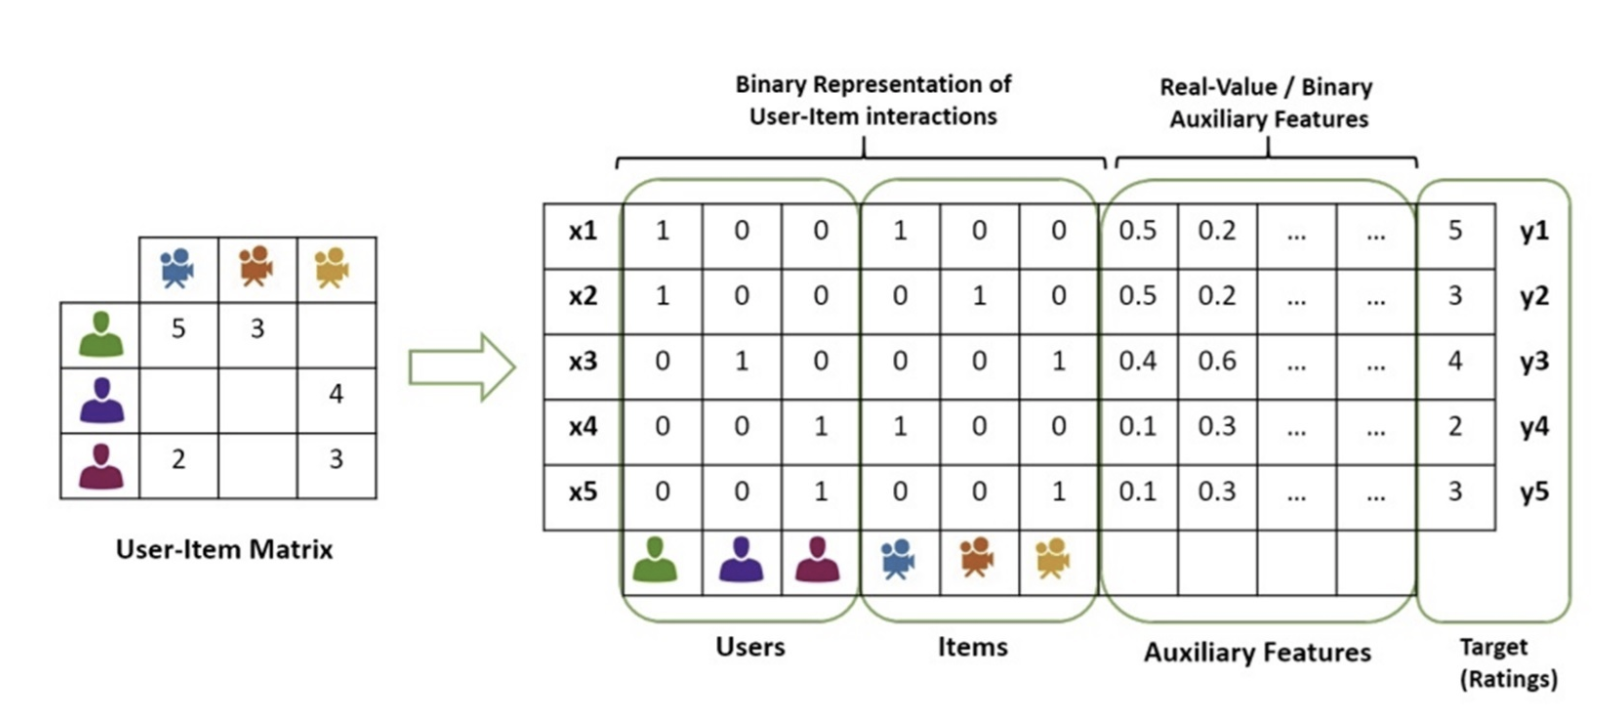

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

In [ ]:
tr_X = np.hstack([to_categorical(train['userId'], len(uuid)), to_categorical(train['movieId'], len(uiid))])
test_X = np.hstack([to_categorical(test['userId'], len(uuid)), to_categorical(test['movieId'], len(uiid))])

tr_X.shape, test_X.shape

((850177, 2), (150032, 2))

### Model architecture

In [ ]:
class FM_layer(keras.Model):
    def __init__(self, x_dim, latent_dim, w_reg=1e-4, v_reg=1e-4):
        super(FM_layer, self).__init__()
        self.x_dim = x_dim
        self.latent_dim = latent_dim
        
        self.w_reg = w_reg
        self.v_reg = v_reg

    def build(self, input_shape):
        self.w_0 = self.add_weight(shape=(1, ),
                                  initializer=tf.zeros_initializer(),
                                  trainable=True)
        
        self.w = self.add_weight(shape=(self.x_dim, 1), 
                             initializer=tf.random_normal_initializer(),
                                trainable=True,
                                regularizer=l2(self.w_reg))
        
        self.V = self.add_weight(shape=(self.x_dim, self.latent_dim), 
                             initializer=tf.random_normal_initializer(),
                                trainable=True,
                                regularizer=l2(self.v_reg))

    def call(self, inputs):
        linear_terms = tf.reduce_sum(tf.matmul(inputs, self.w), axis=1)

        interactions = 0.5 * tf.reduce_sum(
            tf.pow(tf.matmul(inputs, self.V), 2)
            - tf.matmul(tf.pow(inputs, 2), tf.pow(self.V, 2)),
            1,
            keepdims=False
        )

        y_hat = (self.w_0 + linear_terms + interactions)

        return y_hat

In [ ]:
class FM(tf.keras.Model)
    def __init__(self, x_dim, latnt_dim):
        super(FM, self).__init__()
        self.fm = FM_layer(x_dim, latnt_dim)

    def call(self, inputs):
        fm_outputs = self.fm(inputs)
        outputs = tf.nn.sigmoid(fm_outputs)
        return outputs

### Training

In [ ]:
fm = FM(tr_X.shape[1], 8)
fm.compile(loss='binary_crossentropy', optimizer='adam')
fm.fit(tr_X, train['rating'].values,
      epochs=10,
      shuffle=True,
      validation_split=0.1)

### Evaluation

In [ ]:
pred = fm.predict(test_X)
np.sum(np.where(pred>0.5, 1, 0).flatten() == test['rating'].values) / len(pred)

In [ ]:
print(roc_auc_score(test['rating'].values, pred))
print(precision_score(test['rating'].values, np.where(pred>0.5, 1, 0)))
print(recall_score(test['rating'].values, np.where(pred>0.5, 1, 0)))

## PNN

### Abstract

[Product-based Neural Networks for User Response Prediction](https://arxiv.org/pdf/1611.00144.pdf)

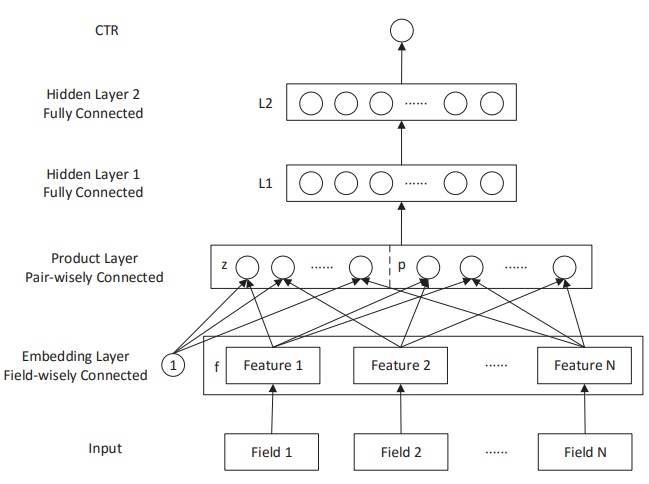

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

In [ ]:
tr_X = np.stack([train['userId'].values.astype(np.int32), train['movieId'].values.astype(np.int32)], 1)
test_X = np.stack([test['userId'].values.astype(np.int32), test['movieId'].values.astype(np.int32)], 1)

tr_X.shape, test_X.shape

((850177, 2), (150032, 2))

### Model architecture

In [ ]:
class InnerProduct(layers.Layer):
    def __init__(self, x_dims):
        super().__init__()
        self.x_dims = x_dims
        
    def call(self, inputs):
        n = len(self.x_dims)
        
        p = []
        q = []
        for i in range(n):
            for j in range(i+1, n):
                p.append(i)
                q.append(j)
                
        p = tf.gather(inputs, p, axis=1)
        q = tf.gather(inputs, q, axis=1)
        
        out = p*q
        out = tf.squeeze(out, 1)
#         out = tf.reduce_sum(out, axis=2)
        return out
    
    
class OuterProduct(layers.Layer):
    def __init__(self, x_dims, kernel_type='mat'):
        super().__init__()
        self.x_dims = x_dims
        self.kernel_type = kernel_type
        
    def build(self, input_shape):
        n, m, k = input_shape
        
        if self.kernel_type == 'mat':
            self.kernel = self.add_weight(shape=(k, (m*(m-1)//2), k), 
                                         initializer = tf.zeros_initializer())
        else:
            self.kernel = self.add_weight(shape=((m*(m-1)//2), k),
                                         initializer = tf.zeros_initializer())
        
    def call(self, inputs):
        n = len(self.x_dims)
        
        p = []
        q = []
        for i in range(n):
            for j in range(i+1, n):
                p.append(i)
                q.append(j)
                
        p = tf.gather(inputs, p, axis=1)
        q = tf.gather(inputs, q, axis=1)
        
        if self.kernel_type == 'mat':
            kp = tf.transpose(tf.reduce_sum(tf.expand_dims(p, 1) * self.kernel, -1), [0, 2, 1])
            out = tf.reduce_sum(kp * q, -1)
        else:
            out = tf.reduce_sum(p * q * tf.expand_dims(self.kernel, 0), -1)
            
        return out

In [ ]:
class PNN(Model):
    def __init__(self, x_dims, latent_dim, dnn_layers, model_type='inner', l2_emb=1e-4):
        super().__init__()
        self.x_dims = x_dims
        self.latent_dim = latent_dim

        self.embedding = Embedding(sum(x_dims)+1, latent_dim, input_length=1, embeddings_regularizer=l2(l2_emb))

        self.linear = Dense(latent_dim)

        if model_type == 'inner':
            self.pnn = InnerProduct(x_dims)
        elif model_type == 'outer':
            self.pnn = OuterProduct(x_dims)
        else:
            raise ValueError('no available model type')
        
        self.dnn = [Dense(unit, activation='relu') for unit in dnn_layers]
        
        self.final = Dense(1)
        
        self.flatten = Flatten()
        
    def call(self, inputs):
        emb = self.embedding(inputs + tf.constant((0, *np.cumsum(self.x_dims)))[:-1])
        
        linear = self.flatten(self.linear(emb))
        quadratic = self.pnn(emb)

        concat = tf.concat([linear, quadratic], -1)
        
        out = concat
        for layer in self.dnn:
            out = layer(out)
        
        out = self.final(out)
        return out

### Training

In [ ]:
ipnn = PNN((len(uuid), len(uiid)), 8, [64, 32])
opnn = PNN((len(uuid), len(uiid)), 8, [64, 32], 'outer')
ipnn.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
            optimizer=optimizers.Adam())

ipnn.fit(tr_X, 
       train['rating'].values,
      epochs=10,
      shuffle=True,
      validation_split=0.1)

In [ ]:
opnn.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
            optimizer=optimizers.Adam())

opnn.fit(tr_X, 
       train['rating'].values,
      epochs=10,
      shuffle=True,
      validation_split=0.1)

### Evaluation

In [ ]:
pred_i = ipnn.predict(test_X)
pred_o = opnn.predict(test_X)
print(np.sum(np.where(pred_i>0., 1, 0).flatten() == test['rating'].values) / len(pred_i))
print(np.sum(np.where(pred_o>0., 1, 0).flatten() == test['rating'].values) / len(pred_o))

In [ ]:
# inner
print(roc_auc_score(test['rating'].values, pred_i))
print(precision_score(test['rating'].values, np.where(pred_i>0., 1, 0)))
print(recall_score(test['rating'].values, np.where(pred_i>0., 1, 0)))

In [ ]:
# outer
print(roc_auc_score(test['rating'].values, pred_o))
print(precision_score(test['rating'].values, np.where(pred_o>0., 1, 0)))
print(recall_score(test['rating'].values, np.where(pred_o>0., 1, 0)))

## W&D

### Abstract

[Wide & Deep Learning for Recommender Systems](https://arxiv.org/abs/1606.07792)

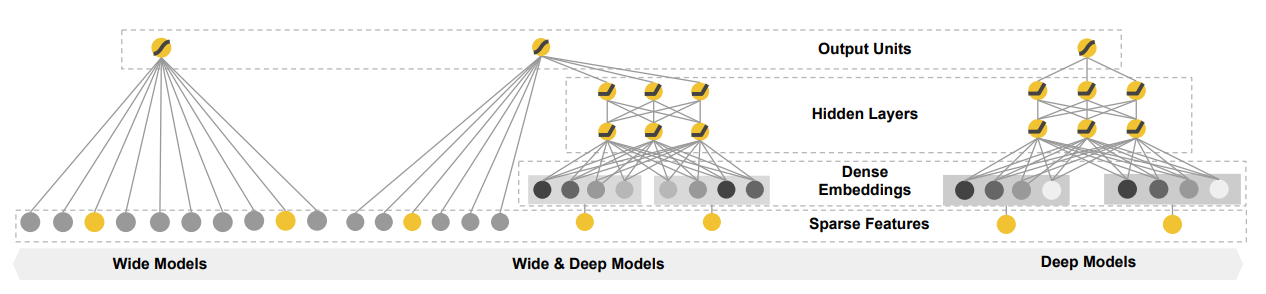

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

In [ ]:
tr_X = np.stack([train['userId'].values.astype(np.int32), train['movieId'].values.astype(np.int32)], 1)
test_X = np.stack([test['userId'].values.astype(np.int32), test['movieId'].values.astype(np.int32)], 1)

tr_X.shape, test_X.shape

((850177, 2), (150032, 2))

### Model architecture

In [ ]:
class WideAndDeep(keras.Model):
    def __init__(self, u_dim, i_dim, u_emb_dim=4, i_emb_dim=4):
        super(WideAndDeep, self).__init__()
        
        self.u_dim = u_dim
        self.i_dim = i_dim
        self.u_emb_dim = u_emb_dim
        self.i_emb_dim = i_emb_dim
        
        self.deep_model = self.build_deep_model()
        self.wide_model = self.build_wide_model()


    def compile(self, wide_optim, deep_optim, loss_fn):
        super(WideAndDeep, self).compile()
        self.wide_optim = wide_optim
        self.deep_optim = deep_optim
        self.loss_fn = loss_fn
    
    def build_deep_model(self):
        u_input = Input(shape=(1, ))
        i_input = Input(shape=(1, ))

        u_emb = Flatten()(Embedding(self.u_dim, self.u_emb_dim, input_length=u_input.shape[1])(u_input))
        i_emb = Flatten()(Embedding(self.i_dim, self.i_emb_dim, input_length=i_input.shape[1])(i_input))

        concat = Concatenate()([u_emb, i_emb])
        
        h = Dense(256, activation='relu')(concat)
        h = Dense(128, activation='relu')(h)
        h = Dense(64, activation='relu')(h)
        h = Dropout(0.2)(h)

        out = Dense(1)(h)
        
        return Model([u_input, i_input], out, name='DeepModel')
    
    def build_wide_model(self):
        u_input = Input(shape=(self.u_dim, ))
        i_input = Input(shape=(self.i_dim, ))

        concat = Concatenate()([u_input, i_input])
        
        out = Dense(1)(concat)
        
        return Model([u_input, i_input], out, name='WideModel')
        
    
    def train_step(self, data):
        X, y = data
        user, item, user_ohe, item_ohe = X
        
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            wide_logit = self.wide_model([user_ohe, item_ohe])
            deep_logit = self.deep_model([user, item])
            logit = 0.5*(wide_logit + deep_logit)
            
            loss = self.loss_fn(y, logit)
            
        wide_grads = tape1.gradient(loss, self.wide_model.trainable_weights)
        self.wide_optim.apply_gradients(zip(wide_grads, self.wide_model.trainable_weights))
        
        deep_grads = tape2.gradient(loss, self.deep_model.trainable_weights)
        self.deep_optim.apply_gradients(zip(deep_grads, self.deep_model.trainable_weights))
        
        return {'loss': loss}
    
    def call(self, data):
        user, item, user_ohe, item_ohe = data
        wide_logit = self.wide_model([user_ohe, item_ohe])
        deep_logit = self.deep_model([user, item])
        return 0.5*(wide_logit + deep_logit)

### Training

In [ ]:
wnd = WideAndDeep(len(uuid), len(uiid))
wnd.compile(
    optimizers.Adam(1e-3),
    optimizers.Adam(1e-3),
    losses.BinaryCrossentropy(from_logits=True)
           )

hist = wnd.fit([train['userId'].values, train['movieId'].values, to_categorical(train['userId']), to_categorical(train['movieId'])],
                   train['rating'].values,
                   shuffle=True,
                   epochs=10,
                   validation_split=0.1
                  )

### Evaluation

In [ ]:
pred = wnd.predict([test['userId'].values, test['movieId'].values, to_categorical(test['userId'], len(uuid)), to_categorical(test['movieId'], len(uiid))])
np.sum(np.where(pred>0, 1, 0).flatten() == test['rating'].values) / len(pred)

In [ ]:
print(roc_auc_score(test['rating'].values, pred.flatten()))
print(precision_score(test['rating'].values, np.where(pred>0, 1, 0).flatten()))
print(recall_score(test['rating'].values, np.where(pred>0, 1, 0).flatten()))

## xDFM

### Abstract

[xDeepFM: Combining Explicit and Implicit Feature Interactions for Recommender Systems](https://arxiv.org/pdf/1803.05170.pdf)

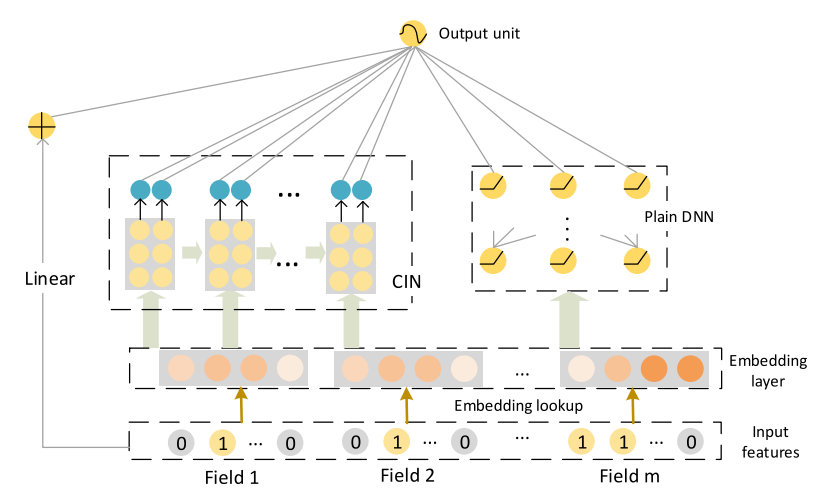

### Load data

In [ ]:
df = load_data('ratings.dat')
df.head()

,userId,movieId,rating
0,0,1104,1.0
1,0,639,1.0
2,0,853,1.0
3,0,3177,1.0
4,0,2162,1.0


In [ ]:
uuid = df['userId'].unique()
uiid = df['movieId'].unique()

### Preprocessing

In [ ]:
train, test = train_test_split(df, test_size=0.15, random_state=SEED, stratify=df['userId'].values)

In [ ]:
tr_X = np.stack([train['userId'].values.astype(np.int32), train['movieId'].values.astype(np.int32)], 1)
test_X = np.stack([test['userId'].values.astype(np.int32), test['movieId'].values.astype(np.int32)], 1)

tr_X.shape, test_X.shape

((850177, 2), (150032, 2))

### Model architecture

In [ ]:
class CIN(layers.Layer):
    def __init__(self, cross_layer_sizes, activation=None):
        super(CIN, self).__init__()
        self.cross_layer_sizes = cross_layer_sizes
        self.n_layers = len(cross_layer_sizes)
        self.activation = None
        
        if activation:
            self.activation = Activation(activation)
        
        self.cross_layers = []
        for corss_layer_size in cross_layer_sizes:
            self.cross_layers.append(Conv1D(corss_layer_size, 1, data_format='channels_first'))
            
        self.linear = Dense(1)
    
    def call(self, inputs): # embedding is input
        batch_size, field_size, emb_size = inputs.shape
        xs = [inputs]

        for i, layer in enumerate(self.cross_layers):
            x = tf.einsum('nie,nje->nije', xs[i], xs[0])
            x = tf.reshape(x, (-1, field_size*xs[i].shape[1] , emb_size))

            x = layer(x)
            if self.activation:
                x = self.activation(x)
            
            xs.append(x)
            
        res = tf.reduce_sum(tf.concat(xs, axis=1), -1)
        return res

In [ ]:
class xDFM(Model):
    def __init__(self, x_dims, latent_dim, cin_layers, dnn_layers, activation=None, l2_emb=1e-4):
        super(xDFM, self).__init__()
        self.x_dims = x_dims
        
        self.embedding = Embedding(sum(x_dims)+1, latent_dim, input_length=1, embeddings_regularizer=l2(l2_emb))
        
        self.linear = Dense(1)
        
        self.dnn_layers = [Dense(n, activation=activation) for n in dnn_layers]
        self.dnn_final = Dense(1)
        
        self.cin_layers = CIN(cin_layers, activation=activation)
        self.cin_final = Dense(1)
        
    def call(self, inputs):
        # only apply ohe for categorical
        n_feat = inputs.shape[-1]
        sparse = [(tf.one_hot(inputs[:,i], self.x_dims[i])) for i in range(n_feat)]
        sparse = tf.concat(sparse, 1)

        emb = self.embedding(inputs + tf.constant((0, *np.cumsum(self.x_dims)))[:-1])

        dnn_input = Flatten()(emb)

        linear_out = self.linear(sparse)
            
        dnn_out = dnn_input
        for dnn_layer in self.dnn_layers:
            dnn_out = dnn_layer(dnn_out)
        dnn_out = self.dnn_final(dnn_out)

        cin_out = self.cin_layers(emb)
        cin_out = self.cin_final(cin_out)

        out = linear_out + dnn_out + cin_out
        
        return out

### Training

In [ ]:
xdfm = xDFM((len(uuid), len(uiid)), 8, [32, 32], [128, 64], 'relu')
# easily overfitting, reduce epochs
xdfm.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
            optimizer=optimizers.Adam())

xdfm.fit(tr_X, 
       train['rating'].values,
      epochs=5,
      shuffle=True,
      validation_split=0.1)

### Evaluation

In [ ]:
pred = xdfm.predict(test_X)
np.sum(np.where(pred>0., 1, 0).flatten() == test['rating'].values) / len(pred)

In [ ]:
print(roc_auc_score(test['rating'].values, pred))
print(precision_score(test['rating'].values, np.where(pred>0., 1, 0)))
print(recall_score(test['rating'].values, np.where(pred>0., 1, 0)))

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-11-28 16:54:57

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy            : 1.19.5
pandas           : 1.1.5
tensorflow_addons: 0.15.0
sys              : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
seaborn          : 0.11.2
keras            : 2.7.0
tensorflow       : 2.7.0
IPython          : 5.5.0
matplotlib       : 3.2.2



---

**END**